In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import pipeline, preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, ShuffleSplit, cross_validate
from sklearn import model_selection, metrics

#import models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from df_transformers import SelectColumnsTransfomer

%matplotlib inline

In [2]:
train_data = pd.read_csv("data/preprocessed_train_data.csv", index_col="PassengerId")
test_data = pd.read_csv("data/preprocessed_test_data.csv", index_col="PassengerId")
print(f"Shape of train data: {train_data.shape}. Shape of test data: {test_data.shape}")

Shape of train data: (891, 53). Shape of test data: (418, 52)


### Разделяем выборку на трейн и тест

In [3]:
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived']
X.shape

(891, 52)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Define a cross validation strategy

In [5]:
seed = 3
scoring = 'accuracy'
n_folds = 7

def accuracy_cv(model):
    kfold = KFold(n_splits=n_folds, random_state=seed)
    return cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)

In [6]:
def accuracy_cv_t(model):
    kfold = KFold(n_splits=n_folds, random_state=seed)
    result = dict()
    result['train_score'] = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    result['test_score'] = metrics.accuracy_score(y_test, predictions)
    return result

## Models

In [7]:
# источник - https://www.kaggle.com/kabure/eda-pipelines-v2-0-easy-to-begineers

clfs = []

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 

clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier(n_estimators=100))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=100))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

In [11]:
# Создадим таблицу для сравнения метрик алгоритмов
MLA_columns = ['MLA Name', 'MLA Train Accuracy Mean', 'MLA Train Accuracy 3*STD']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# Создадим таблицу для сравнения предсказаний алгоритмов
MLA_predict = train_data['Survived']

row_index = 0
for name, model  in clfs:
    MLA_name = name
    MLA_compare.loc[row_index, 'MLA Name'] = name
    
    cv_results = accuracy_cv_t(model)
    
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Train Accuracy 3*STD'] = cv_results['train_score'].std()*3   #let's know the worst that can happen!
    
    row_index+=1

C:\Users\nikita\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Train Accuracy Mean,MLA Train Accuracy 3*STD,MLA Test Accuracy Mean
2,KNN,0.812199,0.0931256,0.835821
5,GradientBoostingClassifier,0.826645,0.0694488,0.835821
4,RandomForestClassifier,0.780096,0.0822858,0.828358
0,LogReg,0.81862,0.0752191,0.824627
6,RidgeClassifier,0.833066,0.0684398,0.824627
1,XGBClassifier,0.794543,0.113546,0.809701
8,ExtraTreesClassifier,0.773676,0.13654,0.802239
7,BaggingRidgeClassifier,0.781701,0.0670709,0.798507
3,DecisionTreeClassifier,0.747994,0.11375,0.742537


Text(0, 0.5, 'Algorithm')

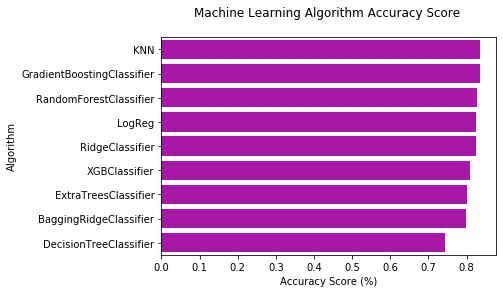

In [13]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [57]:
results, names  = [], [] 

for name, model  in clfs:
    cv_results = accuracy_cv(model)
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

LogReg: 0.818620 (+/- 0.025073)
XGBClassifier: 0.794543 (+/- 0.037849)
KNN: 0.812199 (+/- 0.031042)
DecisionTreeClassifier: 0.749599 (+/- 0.035386)
RandomForestClassifier: 0.781701 (+/- 0.029335)
GradientBoostingClassifier: 0.825040 (+/- 0.020681)
RidgeClassifier: 0.833066 (+/- 0.022813)
BaggingRidgeClassifier: 0.781701 (+/- 0.020681)
ExtraTreesClassifier: 0.764045 (+/- 0.044541)


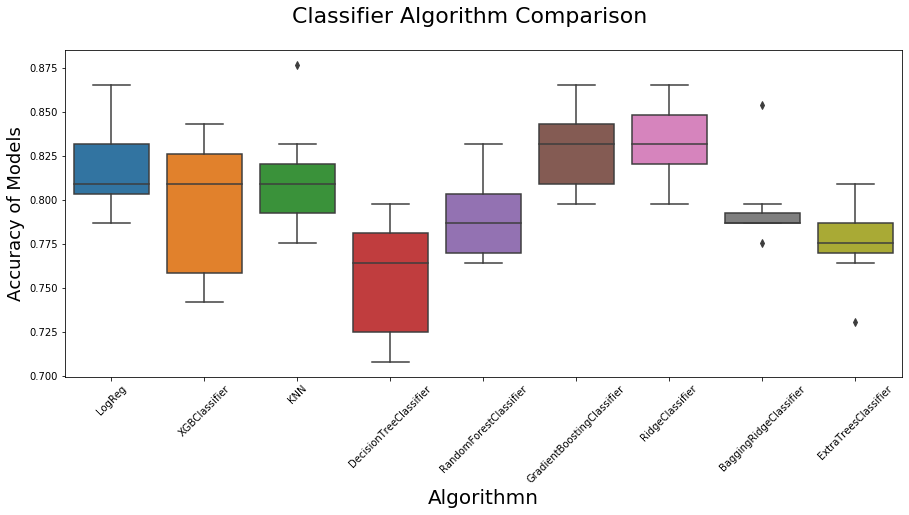

In [9]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [101]:
# Лучшее значение дает GradientBoostingClassifier
gbc = Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=100))])
gbc.fit(X_train, y_train)
predictions = gbc.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))

0.835820895522388


last result 0.835820895522388

## Test data submission

In [102]:
test_data.shape

(418, 52)

In [103]:
gbc.fit(X, y)
predicted = gbc.predict(test_data)
test_data["Survived"] = predicted
test_data["Survived"].to_csv('gbc.csv', header=True)

In [104]:
test_data["Survived"].head()

PassengerId
892    0
893    0
894    0
895    0
896    1
Name: Survived, dtype: int64